In [2]:
import os
import sys
import warnings
import numpy as np

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings('ignore')

# Rie-SNE

**Authors:** Andri Bergsson and Søren Hauberg 

**Affiliation:** Technical University of Denmark, Lyngby

# 1. Introduction and motivation

  Visualizations are crucial to investigators trying to make sense of high-dimensional data. The most common output of a visualization is a two-dimensional plot (e.g. on a piece of paper or a computer screen), so we often call on a form of dimensionality reduction when working with high-dimensional data. The vast majority of dimensionality reduction techniques assume that data resides on a Euclidean domain, which presents a problem when data is not quite that simple. Data residing on Riemannian manifolds, such as the sphere, appear in many domains where either known constraints or other modeling assumptions impose a Riemannian structure . In such settings, how should one visualize data?
  
  There are many concerns and questions when visualizing Riemannian data. The first is generic: all dimensionality reduction tools amplify parts of the signal, while reducing the remainder. This is an inherent limitation, which should always be in mind when interpreting data visualizations. Since some loss of information is inevitable, should we then loosen our grip on the data or its underlying Riemannian structure when such is present? Gauss's *Theorema Egregium* informs us that if the final plot is to be presented on a *flat* screen or piece of paper, then a distortion of the Riemannian structure is inevitable.
  
  In practice, even if one accepts the limitations of a visualization, actual algorithms for visualizing Riemannian data are missing. In this paper, we develop an extension of the *Stochastic Neighbor Embedding* method to Riemannian data and thereby provide one such tool. We call this *Riemannian Stochastic Neighbor Embedding*, or *Rie-SNE* for short. Our approach is quite general as it allows for embedding data observed on one Riemannian manifold to be embedded on another. This allows for mapping data from a Riemannian space to a two-dimensional Euclidean plane (for plotting), but also mapping to a two-dimensional sphere, or similar, when the Euclidean topology is inappropriate. Rie-SNE does not claim to solve the above-mentioned limitations of visualization, but it does provide a working tool, which we demonstrate to have practical merit.
  
<br></br>
<div>
<img src="img/intro_figure.svg" width="500"/>
</div>


# 2. Related Works

## Stochastic neighbor embedding
*Stochastic neighbor embedding (SNE)* is a dimensionality reduction tool, which aims to preserve similarity between neighboring points when mapped to a low-dimensional representation. Assume for now, that we have access to function $s_{\text{high}}$ and $s_{\text{low}}$, which measure the similarity between observation pairs in the high-dimensional observation space and the low-dimensional representation space, respectively.

Now define the conditional probability, $p_{j|i}$ that $x_i$ would pick $x_j$ as its neighbor
\begin{align}
  p_{j|i} = \frac{s_{\text{high}}(x_j | x_i)}{\sum_{k \ne i} s_{\text{high}}(x_k | x_i)}.
  \label{hdimp2}
\end{align}
Common convention is to define $p{i|i} = 0$. Further note that $\sum_j p_{j|i} = 1$. We can renormalize this to form a distribution over all observations as
\begin{gather}
  p_{ij} = \frac{p_{j|i} + p_{i|j}}{2n},
  \label{hdimp1}
\end{gather}
 where $n$ is the number of observations.
    
To learn a low-dimensional representation, the key idea is to repeat the above over the low-dimensional space to form
    \begin{align}
      q_{j|i} &= \frac{s_{\text{low}}(y_j | y_i)}{\sum_{k \ne i} s_{\text{low}}(y_k | y_i)}, \\
      q_{ij}  &= \frac{q_{j|i} + q_{i|j}}{2n}.
    \end{align}
    We can now compare the similarity of our data and the representation by computing the Kullback-Leibler divergence between $p_{ij}$ and $q_{ij}$,
    \begin{align}
      C = \mathrm{KL}\left( P || Q \right) = \sum_{i=1}^n \sum_{j=1}^n p_{ij} \log \frac{p_{ij}}{q_{ij}}.
    \end{align}
    This can then be minimized using gradient descent with respect to the low-dimensional representation $\{ y_i \}_{i=1}^n$.

In its classic form, SNE picks the measures of similarity as Gaussian functions
    \begin{align}
    \begin{split}
      s_{\text{high}}(x_j | x_i)
        &= \left(2\pi\sigma_i^2\right)^{-\frac{D}{2}} \exp\left( -\frac{\| x_j - x_i \|^2}{2\sigma_i^2} \right), \\
      s_{\text{low}}(y_j | y_i)
        &= \left(2\pi\right)^{-\frac{d}{2}} \exp\left( -\frac{\| y_j - y_i \|^2}{2} \right).
    \end{split}\label{eq:sne_s}
    \end{align}
    With this choice, the normalization constants cancel out when computing $p_{j|i}$ and $q_{j|i}$.
    Note that this approach gives a per-observation variance $\sigma_i^2$, such that different points effectively can have different sizes of neighborhoods. To determine the $\sigma_i^2$ parameters, the user specifies a perplexity parameter, which can be thought of as a measure of the effective number of neighbors \cite{vanDerMaaten2008}. This is defined as
    \begin{align}
      \text{perplexity} = 2^{H\left(P_i\right)},
      \label{eq:perplexity}
    \end{align}
    where $H\left(P_i\right)$ is the Shannon entropy of $P_i$ in bits:
    \begin{align}
      H\left(P_i\right) = - \sum_{j} p_{j|i} \log_2 p_{j|i}.
    \end{align}
    For a specific user-provided value of the perplexity parameter, we can perform a binary search over $\sigma_i^2$ such that holds. In practice, the user experiments with different choices of perplexities to see which reveals a pattern.

## The t-distributed stochastic neighbor embedding

The most popular variant of SNE is the *t-distributed SNE*. This is motivated by the so-called 'crowding problem' often observed in SNE, where the low-dimensional representations significantly overlap without revealing much underlying structure. The idea is to use a similarity in representation space with more heavy tails than the Gaussian. Specifically, $s_{\text{low}}$ is chosen as a $t$-distribution with one degree of freedom centered around one representation, i.e.
\begin{align}
  s_{\text{low}}(y_j | y_i)
    &= \pi^{-1} \left( 1 + \|y_j - y_i\|^2 \right)^{-1}.
\end{align}
    
  As is evident, t-SNE needs to compute all pairwise distances between data points and therefore has quadratic complexity. Using approximation techniques, such as vantage-point trees or the *Barnes-Hut approximation*, the running time can be lowered down to having $\mathcal{O}(n \log n)$ complexity

# 3. Implementation of Rie-SNE

## The Rie-SNE Algorithm


### See the file `riesne.py` for the implementation details of Rie-SNE.

# 4. Test on Synthetic Datasets and Benchmark

## Benchmark

# 5. Rie-SNE on MNIST

### Rie-SNE visualization

... some description ...

[Rie-SNE] Starting Rie-SNE ...


Output()

[Rie-SNE] Mean variance:0.053812114397684734
[Rie-SNE] KL divergence after 250 iterations with early exaggeration: 41.93346405029297
[Rie-SNE] KL divergence after 1000 iterations: 0.9677731990814209


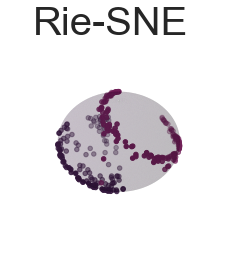

In [2]:
import torch
import torchvision.datasets
from riesne import Riesne
from models.sphere import Sphere


def mnist_test():
    # Determine model.
    model = Sphere(784)

    # Load data.
    subset_size = 300 # -1 equals the entire data set.
    label_thresh = 2 # Include only a subset of MNIST classes.

    mnist_data = torchvision.datasets.MNIST('data/', train=True, download=True)
    X = mnist_data.data.reshape(-1, 784).float() / 255
    Y = mnist_data.targets

    idx = Y < label_thresh # Only use digits 0, 1, 2, ...
    X = X[idx][:subset_size]
    Y = Y[idx][:subset_size]

    # Project MNIST data onto sphere.
    X /= X.norm(dim=1).unsqueeze(1)

    # Run Rie-SNE.
    print(f"[Rie-SNE] Starting Rie-SNE ...")
    riesne = Riesne(model, n_components=3, init='sphere')
    transformed = riesne.fit_transform(X.cpu().numpy())
    model.plot_points(transformed, Y, 'Rie-SNE')

mnist_test()

```{bibliography}
```